In [17]:
import numpy as np
import networkx as nx
import network
import base
import igraph as ig
import itertools
import pandas as pd
from skimage.morphology import disk
import cv2 as cv
import matplotlib.pyplot as plt

In [18]:
def lattice(absc,ordi,w_absc=None,w_ordi=None):
    x = np.arange(0, absc, 1)
    y = np.arange(0, ordi, 1)
    positions =list(itertools.product(x, y))
    G = nx.Graph()
    node_dict_list = list()
    for _id,pos in zip(range(len(positions)),positions):
        node_dict_list.append((_id,dict([('o',pos)])))
    G.add_nodes_from(node_dict_list)
    
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            if (G.nodes[i]['o'][0]-G.nodes[j]['o'][0])==1 and (G.nodes[i]['o'][1]==G.nodes[j]['o'][1]):
                G.add_edge(i,j,weight=w_absc)
            if (G.nodes[i]['o'][1]-G.nodes[j]['o'][1])==1 and (G.nodes[i]['o'][0]==G.nodes[j]['o'][0]):
                G.add_edge(i,j,weight=w_ordi)
    return G

def removal(G,HRate,VRate):
    def HV(node_i, node_j):
        H = abs(node_i['o'][0] - node_j['o'][0]) == 1
        V = abs(node_i['o'][1] - node_j['o'][1]) == 1
        return H, V
        
    for i,j in G.edges():
        H,V = HV(G.nodes(data=True)[i], G.nodes(data=True)[j])
        if H and np.random.rand() < HRate:
            G.remove_edge(i, j)
        if V and np.random.rand() < VRate:
            G.remove_edge(i, j)
            
    return G

def tensor_moments(N):
    flow_tot = 0
    Txx,Txy,Tyy = 0,0,0
    inlet = N.Gr.vcount()
    outlet = inlet-1

    norm = np.max(N.P)
    for edge in N.Gr.es():
        source = edge.source
        target = edge.target
        if source == inlet or target == outlet: continue
        flow = abs(N.P[source] - N.P[target])*edge['Conductance']/norm
        #flow_tot = flow_tot + flow

        Txx = Txx + flow*(float(N.Gr.vs()[source]['o'][0]) - float(N.Gr.vs()[target]['o'][0]))**2
        Txy = Txy + flow*((float(N.Gr.vs()[source]['o'][0]) - float(N.Gr.vs()[target]['o'][0]))*(float(N.Gr.vs()[source]['o'][1]) - float(N.Gr.vs()[target]['o'][1])))
        Tyy = Tyy + flow*(float(N.Gr.vs()[source]['o'][1]) - float(N.Gr.vs()[target]['o'][1]))**2

    T = np.array([[Txx,Txy,0],[Txy,Tyy,0],[0,0,0]])

    return T

"""
def central_square(img_bin):
    #Crop is largest
    image_center = tuple(np.array(img_bin.shape[1::-1]) / 2)
    short_length = img_bin.shape[img_bin.shape == max(img_bin.shape)]
    long_length = max(img_bin.shape)
    ISS = (short_length**2/2)**0.5
    L1 = int((long_length - ISS)/2)
    L3 = int(ISS+L1)
    L2 = int((short_length - ISS)/2)
    L4 = int(ISS+L2)
    crop = [L2,L1,L4,L3]
    
    return crop
"""

def central_square(img_bin):
    #Takes image, returns centered crop which can be fully rotated (i.e. largest inner crop)
    #The diagonal of the inner crop should be as long as the images short_length
    centre = tuple(np.array(img_bin.shape[1::-1]) / 2)
    short_length = img_bin.shape[img_bin.shape == max(img_bin.shape)]
    long_length = max(img_bin.shape)
    diagonal = short_length
    crop_length = (short_length**2/2)**0.5
    L1 = int(centre[0] - crop_length/2)
    L2 = int(centre[0] + crop_length/2)
    L3 = int(centre[1] - crop_length/2)
    L4 = int(centre[1] + crop_length/2)
    crop = [L1,L2,L3,L4]
    
    return crop

# Particle gyrations

<ipython-input-178-d193213a1f0a>:6: RuntimeWarning: covariance is not positive-semidefinite.
  points = np.random.multivariate_normal(mean=(1,1), cov=cov, size=(1000,))


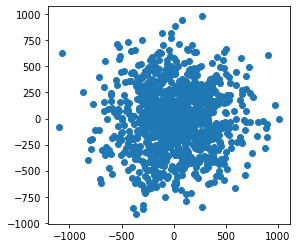

In [178]:
import numpy as np
import matplotlib.pyplot as plt
cov=[[1.5, 0.9], [0.9, 1]]
#cov=A
cov=np.array([[  747.28416, 94775.14574],[94775.14574,  5443.88611]])
points = np.random.multivariate_normal(mean=(1,1), cov=cov, size=(1000,))
points = np.vstack((points.T,np.zeros(len(points)))).T
fix,ax = plt.subplots()

thetar = np.pi/4
r = R.from_quat([0, 0, np.cos(thetar/2), np.sin(thetar/2)])
mat = r.as_matrix()

ax.scatter(points.T[0],points.T[1])
plt.axis('scaled')
plt.show()



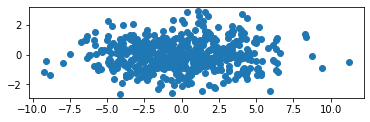

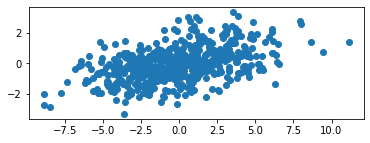

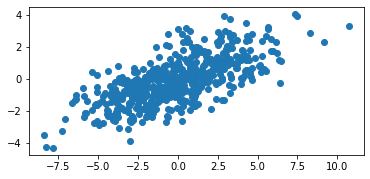

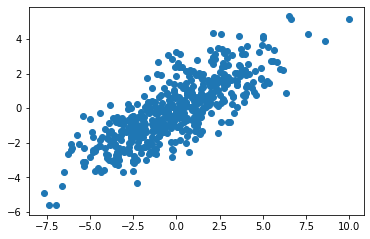

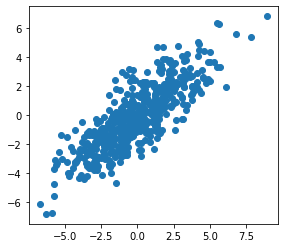

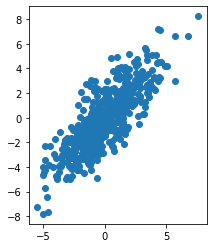

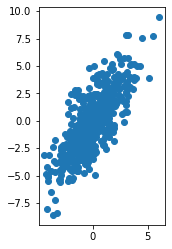

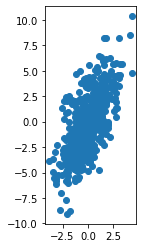

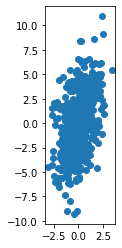

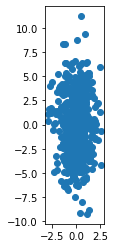

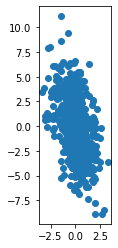

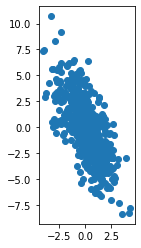

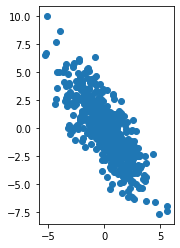

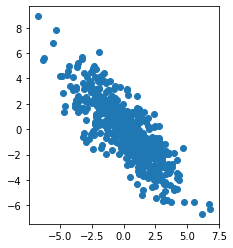

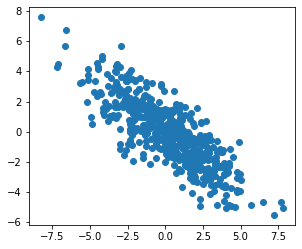

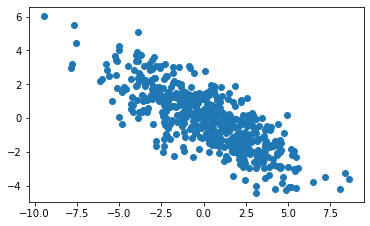

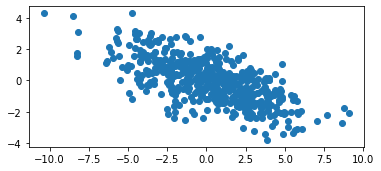

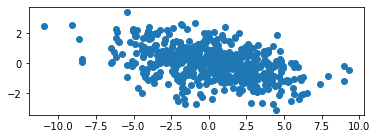

In [246]:
M = []
Axl = []
Ayl = []
points = np.random.multivariate_normal(mean=(0,0), cov=[[10, 0], [0, 1]], size=(500,))
points = np.vstack((points.T,np.zeros(len(points)))).T
from scipy.spatial.transform import Rotation as R
thetas = np.linspace(0,170,18)
#thetas = (0,0.1)
for theta in thetas:
    thetar = theta*np.pi/180
    r = R.from_quat([0, 0, np.cos(thetar/2), np.sin(thetar/2)])
    mat = r.as_matrix()
    pointsN = np.matmul(points, mat)
    plt.scatter(pointsN.T[0], pointsN.T[1])
    plt.axis('scaled')
    plt.show()
    Ax,Ay,Axy,Ayx = 0,0,0,0
    for i in pointsN:
        for j in pointsN:
            Ax  = Ax  + (i[0]-j[0])**2
            Ay  = Ay  + (i[1]-j[1])**2
            Axy = Axy + (i[0]-j[1])*(i[1]-j[0])
    M.append(np.array([[Ax,Axy,0],[Axy,Ay,0],[0,0,0]]))

M = np.asarray(M)  

evals,rot_mat = np.linalg.eig(M)
r = R.from_matrix(rot_mat)
r = r.as_rotvec(degrees=True)
r

points3 = np.matmul(points, rot_mat)

# Model networks

In [23]:

G = lattice(10,5)
g = ig.Graph.from_networkx(G)
A= base.gyration_moments_3(g, weighted=False)
np.linalg.eig(A)

(array([4125., 2000.,    0.]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [27]:
import network
import base
g = network.ResistiveNetwork('TestData/Model_Systems/Rectangle1')
g.binarize()
g.stack_to_gsd(crop=[0,500,0,500])
g.G_u()
g.Gr.vcount()
A = base.gyration_moments_3(g.Gr,weighted=False,sampling=0.1)
np.linalg.eig(A)

3
Ran stack_to_gsd() in  0.06361103057861328 for gsd with  8433 particles
name is  TestData/Model_Systems/Rectangle1/Binarized/skel.gsd
gsd_to_G canvas has shape  (498, 498)
[[ 0 42]]
(0, 2, array([[ 0, 42],
       [ 0, 43],
       [ 1, 44],
       [ 2, 45],
       [ 3, 46],
       [ 4, 47],
       [ 5, 48],
       [ 5, 49],
       [ 6, 50],
       [ 7, 51],
       [ 8, 52],
       [ 9, 53],
       [10, 54],
       [11, 55],
       [12, 55],
       [13, 56],
       [14, 56]], dtype=int16))
Ran gsd_to_G in  0.593440055847168 for a graph with  94 nodes.


(array([ 239710.53217673, 4195589.46782327,       0.        ]),
 array([[-0.99858877,  0.05310817,  0.        ],
        [-0.05310817, -0.99858877,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

In [26]:
A/1000000

array([[ 26.620185, -25.468062,   0.      ],
       [-25.468062, 524.888617,   0.      ],
       [  0.      ,   0.      ,   0.      ]])

In [8]:
A/100000

array([[5739.82963, -285.71613,    0.     ],
       [-285.71613,  266.58011,    0.     ],
       [   0.     ,    0.     ,    0.     ]])

In [ ]:
g = network.ResistiveNetwork('TestData/Model_Systems/Rectangle1')
g.binarize()
Ax_df = []
Ay_df = []
O_eff_df = []
thetas = np.linspace(0,350,72)
for theta in thetas:
    g.stack_to_circular_gsd(274,name='rot_skel.gsd', rotate=theta)
    g.G_u()
    g.potential_distribution(0, [0,100], [540-100,540], R_j=100)
    L = g.L
    Q = np.linalg.pinv(L)
    O_eff = Q[-1,-1]+Q[-2,-2]-2*Q[-1,-2]
    Ax_df.append(Ax)
    Ay_df.append(Ay)
    O_eff_df.append(O_eff)
    base.Node_labelling(g, g.P, 'P', 'Results.gsd')
    Ax,Ay = gyration_moments_3(g.Gr,sampling=1)
    
df = pd.DataFrame(columns=['Theta', 'Ax','Ay', 'O_eff'])
df['Theta'] = thetas
df['Ax'] = Ax_df
df['Ay'] = Ay_df
df['O_eff'] = O_eff_df

In [ ]:
df['O_eff_PERP'] = np.roll(df['O_eff'].values, -9)
df['Selectivity'] = (df['O_eff_PERP']/df['O_eff'])**1
df['Ax/Ay'] = df['Ax']/df['Ay']

In [ ]:
#Ax/Ay - Selectivity
fig, ax1 = plt.subplots()

ax1.scatter(df['Theta'],df['O_eff_PERP'], label=r'$Y_\Omega$', color='tab:blue')
ax1.set_xlabel(r'$\theta\/(deg)$')
ax1.set_ylabel(r'$Y_\Omega$')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.scatter(df['Theta'],df['Ax'], label=r'$A_x/A_y$', color='tab:orange')
#ax2.scatter(df['Theta'],df['Ax/Ay'], label=r'$A_x/A_y$', color='tab:orange')
ax2.set_ylabel(r'$A_x/A_y$')
ax2.set_yscale('log')

fig.legend()
plt.show()

In [ ]:
plt.scatter(df['Theta'],df['Ax'])
plt.scatter(df['Theta'],df['Ay'])
plt.yscale("log")
plt.show()

# Experimental networks: AgNWN

In [ ]:

import pandas as pd
df = pd.read_csv('/Users/alaink/Software/StructuralGTEdits/StructuralGT/TestData/AgNWN_10um/Binarized/Rotations/ObjectImplementation/AgNWN_10um_Rweight_circleGSD_distanceGyration.csv')


In [ ]:
df['O_eff_PERP'] = np.roll(df['O_eff'].values, -9)
df['Selectivity'] = (df['O_eff_PERP']/df['O_eff'])**1
df['Ax/Ay'] = df['Ax']/df['Ay']
plt.scatter(df['Theta'], 1/df['Selectivity'])
plt.scatter(df['Theta'], df['Ax/Ay'])
plt.yscale('log')
plt.show

In [ ]:
df['O_eff_PERP'] = np.roll(df['O_eff'].values, -9)
df['Selectivity'] = (df['O_eff_PERP']/df['O_eff'])**1
df['Ax/Ay'] = df['Ax']/df['Ay']
plt.scatter(df['Theta'], df['Ax'])
plt.scatter(df['Theta'], df['Ay'])
plt.yscale('log')
plt.show

In [ ]:
import gsd.hoomd
traj = gsd.hoomd.open(name='/Users/alaink/Software/StructuralGTEdits/StructuralGT/TestData/AgNWN_10um/Binarized/Rotations/ObjectImplementation/Cweight_circle_displacement.gsd')
AxL = []
AyL = []
for snap in traj:
    points = snap.particles.position[snap.particles.typeid==1]
    Ax,Ay = 0,0
    for i in points:
        for j in points:
            Ax  = Ax  + (i[0]-j[0])**2
            Ay  = Ay  + (i[1]-j[1])**2
    AxL.append(Ax)
    AyL.append(Ay)


# Experimental networks: Mxene (with diagonalisation)

In [35]:
def gyration_moments_3(G, sampling=1):
    Ax=0
    Ay=0
    Axy=0
    node_count = np.asarray(list(range(G.vcount())))
    mask = np.random.rand(G.vcount()) > (1-sampling)
    trimmed_node_count = node_count[mask]
    for i in trimmed_node_count:
        for j in trimmed_node_count:
            if i >= j:    #Symetric matrix
                continue
            
            path = G.get_shortest_paths(i,to=j, weights='Resistance')
            Ax_term  = 0
            Ay_term  = 0
            Axy_term = 0
            for hop_s,hop_t in zip(path[0][0:-1],path[0][1::]):
                weight = G.es[G.get_eid(hop_s,hop_t)]['Conductance']
                Ax_term  = Ax_term  + weight*(((int(G.vs[hop_s]['o'][0])-int(G.vs[hop_t]['o'][0])))**2)
                Ay_term  = Ay_term  + weight*(((int(G.vs[hop_s]['o'][1])-int(G.vs[hop_t]['o'][1])))**2)
                Axy_term = Axy_term + weight*(((int(G.vs[hop_s]['o'][1])-int(G.vs[hop_t]['o'][1])))*((int(G.vs[hop_s]['o'][0])-int(G.vs[hop_t]['o'][0]))))
            Ax  = Ax  + (Ax_term)
            Ay  = Ay  + (Ay_term)
            Axy = Axy + (Axy_term)
            A = np.array([[Ax,Axy,0],[Axy,Ay,0],[0,0,0]])
    return A

In [58]:
scale=1

img_options={"Thresh_method":1, "gamma": 3.45, "md_filter": 1, "g_blur": 1, "autolvl": 1,
             "fg_color":1, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 1, "asize": int((103*scale))*2+1,
             "bsize":int((30*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 127}


#N = network.ResistiveNetwork('TestData/AgNWN_10um')
N = network.ResistiveNetwork('TestData/AgNWN_iso/Single')
#N = network.ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/30_003')
#N = network.ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/100_021')
#N = network.ResistiveNetwork('TestData/Mxene/2')
#N = network.ResistiveNetwork('TestData/AgNWN_iso/LargeSet/200s/004')
#N.binarize(options_dict=img_options)


N.stack_to_circular_gsd(875, debubble=[disk(2)])
#N.stack_to_gsd(crop=[L1,L3,L2,L4], debubble=[disk(2)])
N.G_u()

N.Gr = base.sub_G(N.Gr)
measuring_graph = base.add_weights(N, weight_type='Resistance', R_j=5)
measuring_graph = base.add_weights(N, weight_type='Conductance', R_j=5)


A = gyration_moments_3(measuring_graph,sampling=0.2)


from scipy.spatial.transform import Rotation as R
evals,rot_mat = np.linalg.eig(A)

    
r = R.from_matrix(rot_mat)
r = -r.as_rotvec(degrees=True)
if evals[0]<evals[1]: r = r + 90
if r[2] < 0: r = r + 360
print(rot_mat)
print('evals are ', evals)
print(r)

Ran stack_to_gsd() in  2.8467609882354736 for gsd with  43253 particles
Ran debubble in  1.4735989570617676 for an image with shape  (1, 1764, 2046)
gsd_to_G canvas has shape  (1748, 1750)
[[ 11 831]]
(0, 1, array([[ 11, 831],
       [ 10, 830],
       [ 10, 829],
       [  9, 828],
       [  9, 827],
       [  9, 826],
       [  9, 825],
       [  9, 824],
       [  9, 823],
       [  9, 822],
       [ 10, 821],
       [ 10, 820],
       [ 10, 819],
       [ 11, 818],
       [ 11, 817],
       [ 12, 816]], dtype=int16))
Ran gsd_to_G in  4.305454969406128 for a graph with  1284 nodes.
pre sub has  1284  nodes
post sub has  151  nodes
[[ 0.89075391 -0.45448594  0.        ]
 [ 0.45448594  0.89075391  0.        ]
 [ 0.          0.          1.        ]]
evals are  [2324779.54469777 1359453.55526568       0.        ]
[360.         360.         332.96813658]


[  0 255]
Ran stack_to_gsd() in  2.6536550521850586 for gsd with  38715 particles
Ran debubble in  1.4182229042053223 for an image with shape  (1, 1757, 2033)
name is  TestData/Mxene/1/Binarized/debubbled_circle.gsd
gsd_to_G canvas has shape  (1700, 1700)
[[ 18 892]]
(0, 40, array([[ 18, 892],
       [ 19, 893],
       [ 20, 894],
       [ 20, 895],
       [ 21, 896],
       [ 22, 897],
       [ 23, 898],
       [ 24, 898],
       [ 25, 898],
       [ 26, 899],
       [ 27, 899],
       [ 28, 900],
       [ 29, 900],
       [ 30, 901],
       [ 31, 901],
       [ 32, 901],
       [ 33, 902],
       [ 34, 902],
       [ 35, 903],
       [ 36, 903],
       [ 37, 903],
       [ 38, 903],
       [ 39, 904],
       [ 40, 904],
       [ 41, 904],
       [ 42, 905],
       [ 43, 905],
       [ 44, 905],
       [ 45, 905],
       [ 46, 906],
       [ 47, 906],
       [ 48, 907],
       [ 49, 907],
       [ 50, 908],
       [ 51, 908],
       [ 52, 909],
       [ 53, 909],
       [ 54, 910],
  

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

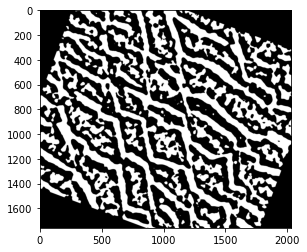

[  0 255]
Ran stack_to_gsd() in  3.3043441772460938 for gsd with  38836 particles
Ran debubble in  1.5416641235351562 for an image with shape  (1, 1758, 2048)
name is  TestData/Mxene/2/Binarized/debubbled_circle.gsd
gsd_to_G canvas has shape  (1698, 1694)
[[  3 874]]
(0, 98, array([[   3,  874],
       [   4,  873],
       [   5,  872],
       [   6,  871],
       [   7,  870],
       [   8,  869],
       [   9,  868],
       [  10,  867],
       [  11,  866],
       [  12,  865],
       [  13,  864],
       [  14,  863],
       [  15,  862],
       [  16,  861],
       [  17,  860],
       [  18,  859],
       [  19,  858],
       [  20,  857],
       [  21,  857],
       [  22,  857],
       [  23,  856],
       [  24,  856],
       [  25,  856],
       [  26,  857],
       [  27,  857],
       [  28,  857],
       [  29,  857],
       [  30,  857],
       [  31,  857],
       [  32,  857],
       [  33,  857],
       [  34,  857],
       [  35,  857],
       [  36,  857],
       [  

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

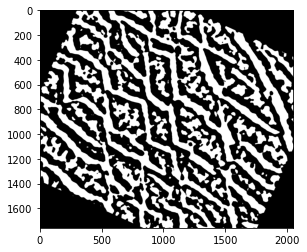

[  0 255]
Ran stack_to_gsd() in  2.3034958839416504 for gsd with  40602 particles
Ran debubble in  1.5462322235107422 for an image with shape  (1, 1742, 2036)
name is  TestData/Mxene/3/Binarized/debubbled_circle.gsd
gsd_to_G canvas has shape  (1690, 1699)
[[  9 810]]
(0, 12, array([[  9, 810],
       [ 10, 810],
       [ 11, 810],
       [ 12, 810],
       [ 13, 809],
       [ 14, 808],
       [ 15, 808],
       [ 16, 809],
       [ 17, 808],
       [ 18, 807],
       [ 19, 806],
       [ 20, 806],
       [ 21, 806],
       [ 22, 805],
       [ 23, 804],
       [ 24, 803],
       [ 25, 802],
       [ 26, 801],
       [ 27, 800],
       [ 28, 799],
       [ 29, 798],
       [ 30, 797],
       [ 31, 796],
       [ 32, 795]], dtype=int16))
Ran gsd_to_G in  4.200703144073486 for a graph with  1398 nodes.
calling add weights
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Res

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

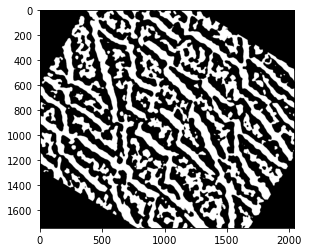

[  0 255]
Ran stack_to_gsd() in  2.289543867111206 for gsd with  34770 particles
Ran debubble in  1.4417378902435303 for an image with shape  (1, 1766, 2047)
name is  TestData/Mxene/4/Binarized/debubbled_circle.gsd
gsd_to_G canvas has shape  (1695, 1693)
[[ 10 852]]
(0, 6, array([[ 10, 852],
       [ 11, 852],
       [ 12, 852],
       [ 13, 851],
       [ 14, 851],
       [ 15, 852],
       [ 16, 852],
       [ 17, 851],
       [ 18, 851],
       [ 19, 851],
       [ 20, 851],
       [ 21, 851],
       [ 22, 851],
       [ 23, 851],
       [ 24, 851],
       [ 25, 851],
       [ 26, 851],
       [ 27, 851],
       [ 28, 851],
       [ 29, 852],
       [ 30, 852],
       [ 31, 852],
       [ 32, 852],
       [ 33, 852],
       [ 34, 852]], dtype=int16))
Ran gsd_to_G in  3.8800148963928223 for a graph with  1091 nodes.
calling add weights
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resista

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

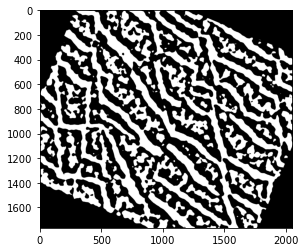

[  0 255]
Ran stack_to_gsd() in  2.267033815383911 for gsd with  34271 particles
Ran debubble in  1.440535068511963 for an image with shape  (1, 1749, 2036)
name is  TestData/Mxene/5/Binarized/debubbled_circle.gsd
gsd_to_G canvas has shape  (1700, 1696)
[[ 14 862]]
(0, 25, array([[ 14, 862],
       [ 15, 862],
       [ 16, 861],
       [ 17, 861],
       [ 18, 861],
       [ 19, 862],
       [ 20, 861],
       [ 21, 861],
       [ 22, 861],
       [ 23, 862],
       [ 24, 861],
       [ 25, 861],
       [ 26, 861],
       [ 27, 861],
       [ 28, 861],
       [ 29, 861],
       [ 30, 860],
       [ 31, 860],
       [ 32, 860],
       [ 33, 860],
       [ 34, 860],
       [ 35, 860],
       [ 36, 860],
       [ 37, 859],
       [ 38, 859],
       [ 39, 859],
       [ 40, 859],
       [ 41, 859],
       [ 42, 860],
       [ 43, 860],
       [ 44, 861],
       [ 45, 862],
       [ 46, 862],
       [ 47, 863],
       [ 48, 863],
       [ 49, 863],
       [ 50, 863],
       [ 51, 863],
    

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

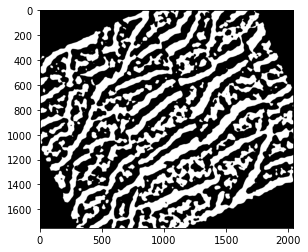

[  0 255]
Ran stack_to_gsd() in  2.2485849857330322 for gsd with  35362 particles
Ran debubble in  1.4359080791473389 for an image with shape  (1, 1740, 2036)
name is  TestData/Mxene/6/Binarized/debubbled_circle.gsd
gsd_to_G canvas has shape  (1700, 1698)
[[  2 882]]
(0, 8, array([[  2, 882],
       [  3, 881],
       [  4, 881],
       [  5, 880],
       [  6, 881],
       [  7, 881],
       [  8, 881],
       [  9, 881],
       [ 10, 881],
       [ 11, 881],
       [ 12, 881],
       [ 13, 881],
       [ 14, 881],
       [ 15, 881],
       [ 16, 882],
       [ 17, 882],
       [ 18, 883],
       [ 19, 883],
       [ 20, 883],
       [ 21, 884],
       [ 22, 884],
       [ 23, 885],
       [ 24, 886],
       [ 25, 886],
       [ 26, 886],
       [ 27, 887],
       [ 28, 887],
       [ 29, 887],
       [ 30, 887],
       [ 31, 887],
       [ 32, 887],
       [ 33, 887],
       [ 34, 887],
       [ 35, 887],
       [ 36, 887],
       [ 37, 887],
       [ 38, 887],
       [ 39, 887],
   

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

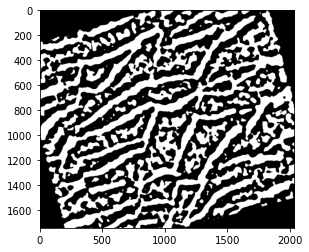

[  0 255]
Ran stack_to_gsd() in  2.302932024002075 for gsd with  34734 particles
Ran debubble in  1.4471428394317627 for an image with shape  (1, 1757, 2047)
name is  TestData/Mxene/7/Binarized/debubbled_circle.gsd
gsd_to_G canvas has shape  (1697, 1700)
[[  9 942]]
(0, 14, array([[  9, 942],
       [ 10, 942],
       [ 11, 942],
       [ 12, 942],
       [ 13, 942],
       [ 14, 942],
       [ 15, 942],
       [ 16, 943],
       [ 17, 942],
       [ 18, 942],
       [ 19, 942],
       [ 20, 943],
       [ 21, 943],
       [ 22, 944],
       [ 23, 944],
       [ 24, 944],
       [ 25, 945],
       [ 26, 945],
       [ 27, 946],
       [ 28, 946],
       [ 29, 946],
       [ 30, 946],
       [ 31, 947],
       [ 32, 948],
       [ 33, 949],
       [ 34, 949],
       [ 35, 949],
       [ 36, 950],
       [ 37, 950],
       [ 38, 951],
       [ 39, 952],
       [ 40, 952],
       [ 41, 953],
       [ 42, 954],
       [ 43, 954],
       [ 44, 955],
       [ 45, 956],
       [ 46, 957],
   

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

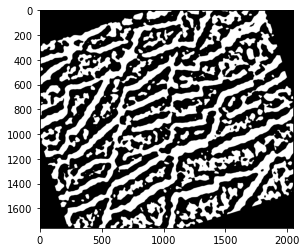

In [40]:
def gyration_moments_3(G, sampling=1):
    Ax=0
    Ay=0
    Axy=0
    node_count = np.asarray(list(range(G.vcount())))
    mask = np.random.rand(G.vcount()) > (1-sampling)
    trimmed_node_count = node_count[mask]
    for i in trimmed_node_count:
        for j in trimmed_node_count:
            if i >= j:    #Symetric matrix
                continue
            
            path = G.get_shortest_paths(i,to=j, weights='Resistance')
            Ax_term  = 0
            Ay_term  = 0
            Axy_term = 0
            for hop_s,hop_t in zip(path[0][0:-1],path[0][1::]):
                weight = G.es[G.get_eid(hop_s,hop_t)]['Conductance']
                Ax_term  = Ax_term  + weight*(((float(G.vs[hop_s]['o'][0])-float(G.vs[hop_t]['o'][0])))**2)
                Ay_term  = Ay_term  + weight*(((float(G.vs[hop_s]['o'][1])-float(G.vs[hop_t]['o'][1])))**2)
                Axy_term = Axy_term + weight*(((float(G.vs[hop_s]['o'][1])-float(G.vs[hop_t]['o'][1])))*((float(G.vs[hop_s]['o'][0])-float(G.vs[hop_t]['o'][0]))))
            Ax  = Ax  + (Ax_term)
            Ay  = Ay  + (Ay_term)
            Axy = Axy + (Axy_term)
            A = np.array([[Ax,Axy,0],[Axy,Ay,0],[0,0,0]])
    return A

img_list = []
flow_vector_list = []
evals_list = []
O=[]
r_list=[]
samples = (3,4)
samples = (1,2,3,4,5,6,7)
for i in samples:
    N = network.ResistiveNetwork('TestData/Mxene/'+str(i))
    N.stack_to_circular_gsd(850, debubble=[disk(2)])
    #N.stack_to_gsd(crop = [0,1700,0,1700], debubble=[disk(2)])
    N.G_u(weight_type=['Resistance','Conductance'], R_j=5)

    base.G_to_gsd(N.Gr, N.stack_dir + '/measuring_graph.gsd')
    A = base.gyration_moments_3(N.Gr,sampling=0.1)

    from scipy.spatial.transform import Rotation as R
    evals,rot_mat = np.linalg.eig(A)

    r = R.from_matrix(rot_mat)
    r = -r.as_rotvec(degrees=True)
    if evals[0]<evals[1]:
        evals = [evals[1],evals[0]]
        r[2] = r[2] + 90
        flow_vector = rot_mat[0]
    else:
        flow_vector = rot_mat[1]
    if r[2] < 0: r = r + 360
    
    r_list.append(r[2])
    img_bin = cv.imread(N.stack_dir+'/slice0.tiff') #Original image
    image_center = tuple(np.array(img_bin.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, r[2], 1.0)
    rot_img = cv.warpAffine(img_bin, rot_mat, img_bin.shape[1::-1], flags=cv.INTER_LINEAR)
    img_list.append(img_bin)
    flow_vector_list.append(flow_vector)
    evals_list.append(evals)
    plt.imshow(rot_img)
    plt.show()
    
    """
    N.stack_to_circular_gsd(850, debubble=[disk(1)], rotate=r[2], name='rot_skel.gsd')
    N.G_u()
    N.Gr = base.sub_G(N.Gr)
    N.potential_distribution(1, [0,100], [1600,1700], R_j=0)
    O.append(N.effective_resistance())
    N.potential_distribution(0, [0,100], [1600,1700], R_j=0)
    O.append(N.effective_resistance())
    """
    

In [46]:
np.linalg.eig(np.array([[1,1,0],[1,1,0],[0,0,0]]))

(array([2., 0., 0.]),
 array([[ 0.70710678, -0.70710678,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

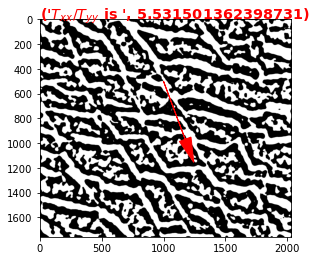

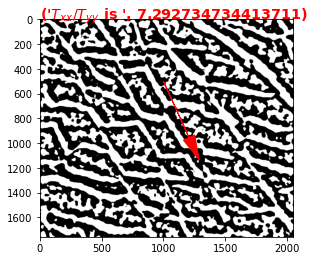

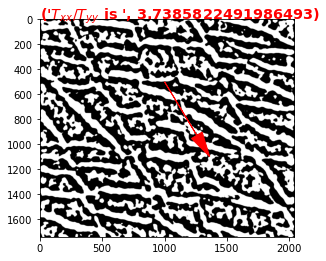

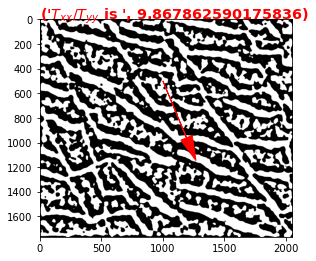

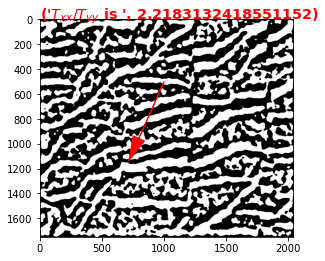

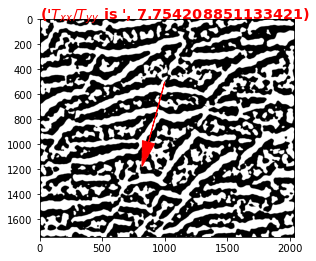

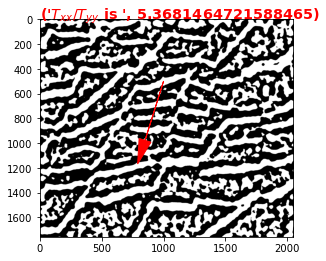

In [41]:
for img, vector, evals, in zip(img_list, flow_vector_list, evals_list):
    fig, ax1 = plt.subplots()
    plt.arrow(1000,500,(vector[0])*500,(vector[1])*500, head_width=100, head_length=200,ec='red',fc='red')
    plt.annotate(str((r'$T_{xx}/T_{yy}$ is ', evals[0]/evals[1])) ,(0,0), color='red',size='x-large',weight='bold')
    plt.imshow(img)
    plt.show()

# Experimental networks (AgNWN) - Discrete rotations - Testing binarisation
## Concentration dependence (isotropic films)

In [181]:
names = {
    #"Rx=72Ry=79":['009','010','011','012','013','019','020','021','022','023'],
    #"Rx=95Ry=91":['009','010','011','012','013','014'],
    #"Rx=159Ry=169":['006','007','008','009','010','011','012','013','005'],
    "Rx=244Ry=229":['002','003','004','005','006','007','008','009','010','011']
}

"""
names = {
    "Rx=72Ry=79":['009','010','011'],
    "Rx=95Ry=91":['009','010','011'],
    "Rx=159Ry=169":['006','007','008'],
    "Rx=244Ry=229":['002','003','004']
}
"""

'\nnames = {\n    "Rx=72Ry=79":[\'009\',\'010\',\'011\'],\n    "Rx=95Ry=91":[\'009\',\'010\',\'011\'],\n    "Rx=159Ry=169":[\'006\',\'007\',\'008\'],\n    "Rx=244Ry=229":[\'002\',\'003\',\'004\']\n}\n'

In [185]:
scale=1

options = {
    "Rx=72Ry=79":{"Thresh_method":0, "gamma": 0.63, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 0, "asize": int((1*scale))*2+1,
             "bsize":int((5*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 65},
    "Rx=95Ry=91":{"Thresh_method":0, "gamma": 0.63, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 0, "asize": int((1*scale))*2+1,
             "bsize":int((5*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 65},
    "Rx=159Ry=169":{"Thresh_method":0, "gamma": 0.5, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 0, "asize": int((301*scale))*2+1,
             "bsize":int((3*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 75},
    "Rx=244Ry=229":{"Thresh_method":0, "gamma": 0.5, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 0, "asize": int((301*scale))*2+1,
             "bsize":int((3*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 75}
}


options = {
    "Rx=72Ry=79":{"Thresh_method":1, "gamma": 0.25, "md_filter": 0, "g_blur": 0, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 1, "asize": int((200*scale))*2+1,
             "bsize":int((5*scale))*2+1, "wsize": int((8*scale))*2+1, "thresh": 60},
    "Rx=95Ry=91":{"Thresh_method":0, "gamma": 0.65, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 0, "asize": int((1*scale))*2+1,
             "bsize":int((5*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 65},
    "Rx=159Ry=169":{"Thresh_method":1, "gamma": 0.2, "md_filter": 0, "g_blur": 0, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 1, "asize": int((200*scale))*2+1,
             "bsize":int((5*scale))*2+1, "wsize": int((5*scale))*2+1, "thresh": 60},
    "Rx=244Ry=229":{"Thresh_method":0, "gamma": 0.5, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 0, "asize": int((1*scale))*2+1,
             "bsize":int((5*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 70}
}

df = pd.DataFrame(columns=['R', 'Replicate', 'O_eff_x', 'O_eff_y'])

R_df=[]
Replicate_df=[]
O_eff_x_df=[]
O_eff_y_df=[]
Ax_df = []
for R in names:
    for replicate in names[R]:
        network_name = 'TestData/AgNWN_loflo/' + R + '/' + replicate
        N = network.ResistiveNetwork(network_name)
        N.binarize(options_dict=options[R])
        
        N.stack_to_gsd(crop=[0,2047,0,2047], debubble=[disk(2)])
        N.G_u()
        if N.Gr.vcount() > 10000: continue
        N.potential_distribution(0, [0,50], [2047-50,2047], R_j=12, rho_dim=0.71)
        Ax = base.gyration_moments_3(N.Gr, sampling=0.1)
        O_eff_x_df.append(N.effective_resistance())
        N.G_u()
        N.potential_distribution(1, [0,50], [2047-50,2047], R_j=12, rho_dim=0.71)
        O_eff_y_df.append(N.effective_resistance())
        
        R_df.append(R)
        Replicate_df.append(replicate)

df['R']=R_df
df['Replicate']=Replicate_df
df['O_eff_x']=O_eff_x_df
df['O_eff_y']=O_eff_y_df
df

11
11
11
11
11
11
11
11
11
11


,R,Replicate,O_eff_x,O_eff_y


## Aligned films

In [34]:
scale=1
options =img_options = {"Thresh_method": 0, "gamma": 1.45, "md_filter": 0, "g_blur": 1, "autolvl": 0, 
                        "fg_color": 0, "laplacian": 0, "scharr": 0, "sobel": 0, "lowpass": 0, "asize": 11, 
                        "bsize": "3", "wsize": 10, "thresh": 120}
df = pd.DataFrame(columns=['R', 'O_eff_x', 'O_eff_y'])

R_df=[]
Replicate_df=[]
O_eff_x_df=[]
O_eff_y_df=[]
Ax_df = []

#network_name = '/Users/alaink/Software/StructuralGTEdits/StructuralGT/TestData/AgNWN_Aligned/GT_Subset/100_021/'
network_name = '/Users/alaink/Software/StructuralGTEdits/StructuralGT/TestData/AgNWN_10um/'
N = network.ResistiveNetwork(network_name)
N.binarize(options_dict=options)       
N.stack_to_gsd(crop=[0,1000,0,1000], debubble=[disk(2)])
N.G_u()
N.potential_distribution(0, [0,50], [1000-10,1000], R_j=12, rho_dim=0.89)
O_eff_x_df.append(N.effective_resistance())
N.G_u()
N.potential_distribution(1, [0,50], [1000-10,1000], R_j=12, rho_dim=0.89)
O_eff_y_df.append(N.effective_resistance())
        
df['R']=R_df
df['Replicate']=Replicate_df
df['O_eff_x']=O_eff_x_df
df['O_eff_y']=O_eff_y_df
df

3


/Users/alaink/miniconda3/envs/v3_env/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Ran stack_to_gsd() in  0.7562210559844971 for gsd with  114561 particles
Ran debubble in  0.6482899188995361 for an image with shape  (1, 1000, 1000)
name is  /Users/alaink/Software/StructuralGTEdits/StructuralGT/TestData/AgNWN_10um//Binarized/debubbled_skel.gsd
gsd_to_G canvas has shape  (1000, 1000)
[[ 0 48]]
(0, 121, array([[ 0, 48],
       [ 1, 48],
       [ 2, 47],
       [ 3, 46],
       [ 4, 45],
       [ 5, 45],
       [ 6, 44],
       [ 7, 44],
       [ 8, 43],
       [ 9, 42],
       [10, 41],
       [10, 40]], dtype=int16))
Ran gsd_to_G in  6.493701219558716 for a graph with  4912 nodes.
name is  /Users/alaink/Software/StructuralGTEdits/StructuralGT/TestData/AgNWN_10um//Binarized/debubbled_skel.gsd
gsd_to_G canvas has shape  (1000, 1000)
[[ 0 48]]
(0, 121, array([[ 0, 48],
       [ 1, 48],
       [ 2, 47],
       [ 3, 46],
       [ 4, 45],
       [ 5, 45],
       [ 6, 44],
       [ 7, 44],
       [ 8, 43],
       [ 9, 42],
       [10, 41],
       [10, 40]], dtype=int16))
Ran

/Users/alaink/miniconda3/envs/v3_env/lib/python3.9/site-packages/StructuralGT-1.0.1b2-py3.9.egg/StructuralGT/GetWeights_3d.py:32: RuntimeWarning: invalid value encountered in true_divide


Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

,R,O_eff_x,O_eff_y,Replicate
0,NaN,29.683732,279.838328,NaN


In [12]:
from StructuralGT import network, base
import numpy as np
N = network.ResistiveNetwork('TestData/AgNWN_iso/LargeSet/200s/006')
N.binarize()

Axx,Ayy,Axy = [],[],[]
Txx,Tyy,Txy = [],[],[]
thetas = (45,)
for theta in thetas:
    N.stack_to_gsd(crop=[407, 1127, 149, 869], rotate=theta, debubble=[disk(2)])
    N.G_u(weight_type=['Resistance','Conductance'], R_j=0)

    #A = base.gyration_moments_3(N.Gr, sampling=0.2)
    #Axx.append(A[0][0])
    #Axy.append(A[1][0])
    #Ayy.append(A[1][1])
    #N.potential_distribution(0, [0,10], [300-10,300], R_j=12, rho_dim=0.71)
    #print(N.effective_resistance())
    base.G_to_gsd(N.Gr, N.stack_dir + '/DGR_test.gsd')

    #T = tensor_moments(N)
    #Txx.append(T[0][0])
    #Txy.append(T[1][0])
    #Tyy.append(T[1][1])
    
    

11
Ran stack_to_gsd() in  0.6073801517486572 for gsd with  73878 particles
Ran debubble in  0.6477658748626709 for an image with shape  (1, 1018, 1019)
name is  TestData/AgNWN_iso/LargeSet/200s/006/Binarized/debubbled_skel.gsd
gsd_to_G canvas has shape  (1018, 1019)
[[1 0]
 [2 1]]
(1, 49, array([[ 1, 77],
       [ 1, 76],
       [ 2, 75],
       [ 3, 74],
       [ 3, 73],
       [ 4, 72],
       [ 5, 71],
       [ 5, 70],
       [ 6, 69],
       [ 7, 68],
       [ 8, 67],
       [ 9, 66]], dtype=int16))
Ran gsd_to_G in  3.7274088859558105 for a graph with  4007 nodes.
calling add weights
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistanc

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

In [323]:
Txx = np.asarray(Txx)
Txy = np.asarray(Txy)
Tyy = np.asarray(Tyy)
Axx = np.asarray(Axx)
Axy = np.asarray(Axy)
Ayy = np.asarray(Ayy)

Txx = np.roll(Txx, -9)
Txy = np.roll(Txy, -9)
Tyy = np.roll(Tyy, -9)


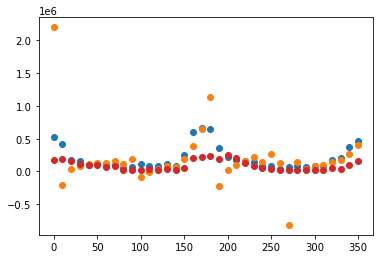

In [324]:

fig, ax1 = plt.subplots()

ax1.scatter(thetas,Axx/Txx)
ax1.scatter(thetas,Axy/Txy, color='tab:orange')
ax1.scatter(thetas,Ayy/Tyy, color='tab:red' )
#ax1.set_ylim(-1.5e6,1.5e6)

plt.show()

# AgNWN (selecting eigenvectors)

11


/Users/alaink/miniconda3/envs/v3_env/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Ran stack_to_gsd() in  0.5231673717498779 for gsd with  48968 particles
Ran debubble in  0.4520070552825928 for an image with shape  (1, 1000, 1000)
name is  TestData/AgNWN_iso/LargeSet/100s/010/Binarized/debubbled_skel.gsd
gsd_to_G canvas has shape  (1000, 1000)
[[  0 132]
 [  0 133]]
(1, 39, array([[  0, 325],
       [  1, 325],
       [  2, 326],
       [  3, 327],
       [  4, 328],
       [  5, 328],
       [  6, 329]], dtype=int16))
Ran gsd_to_G in  2.4958088397979736 for a graph with  2681 nodes.
calling add weights
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistanc

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance
Resistance

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Conductance
Cond

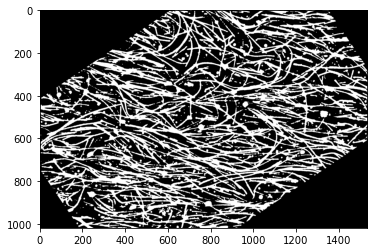

In [3]:
img_list = []
flow_vector_list = []
evals_list = []
O=[]
r_list=[]

#name = 'TestData/AgNWN_iso/LargeSet/100s/010'
#name = 'TestData/AgNWN_Aligned/GT_Subset/100_020'
#name = 'TestData/AgNWN_iso/LargeSet/30s/011'
#img_options = {"Thresh_method":1, "gamma": 0.33, "md_filter": 0, "g_blur": 1,"autolvl": 0, "fg_color":0, "laplacian": 0, "scharr": 0, "sobel": 0,"lowpass": 0, "asize": 203, "bsize": 11, "wsize": 10, "thresh": 70}
N = network.ResistiveNetwork(name)
N.binarize()
crop=central_square(cv.imread(N.stack_dir+'/slice0.tiff'))
#N.stack_to_circular_gsd(360)
N.stack_to_gsd(crop=[0,1000,0,1000], debubble=[disk(2)])
N.G_u(weight_type=['Resistance','Conductance'])
N.Gr = base.sub_G(N.Gr)
base.G_to_gsd(N.Gr, N.stack_dir + '/measuring_graph.gsd')

A = base.gyration_moments_3(N.Gr,sampling=0.2)

from scipy.spatial.transform import Rotation as R
evals,rot_mat = np.linalg.eig(A)

#Get angle
r = R.from_matrix(rot_mat)
angle = -r.as_rotvec(degrees=True)
"""
#Reverse
#r = R.from_rotvec(angle)
#rot_mat = r.as_matrix()

N = network.ResistiveNetwork(name)
#N.stack_to_gsd(crop=central_square(cv.imread(N.stack_dir+'/slice0.tiff')), debubble=[disk(2)], rotate=r[2])
N.stack_to_gsd(crop=crop, debubble=[disk(2)], rotate=angle[2])
#N.stack_to_circular_gsd(360, rotate=angle[2])
N.G_u(weight_type=['Resistance','Conductance'])
base.G_to_gsd(N.Gr, N.stack_dir + '/aligned_graph.gsd')
A1 = base.gyration_moments_3(N.Gr,sampling=0.2)

N = network.ResistiveNetwork(name)
#N.stack_to_gsd(crop=central_square(cv.imread(N.stack_dir+'/slice0.tiff')), debubble=[disk(2)], rotate=r[2])
N.stack_to_gsd(crop=crop, debubble=[disk(2)], rotate=angle[2]+90)
#N.stack_to_circular_gsd(360, rotate=angle[2]+90)
N.G_u(weight_type=['Resistance','Conductance'])
base.G_to_gsd(N.Gr, N.stack_dir + '/aligned_graph_90.gsd')
A2 = base.gyration_moments_3(N.Gr,sampling=0.2)


if A1[0][0]<A[0][0]:
    print('got shorter...')
    if A1[0][0]<A2[0][0]:
        print('...because I became horizontal')
        final = angle[2]
    elif A2[0][0]<A[0][0]:
        print('...because I was vertical')
        final = 90
elif A1[0][0]>A[0][0]:
    print('got longer...')
    if A2[0][0]>A[0][0]:
        print('...because I was horizontal')
        final = None
    elif A1[0][0] > A2[0][0]:
        print('...because I became vertical')
        final = angle[2]+90
"""
#flow_vector = rot_mat[0]
if angle[2] < 0: angle = angle + 360

img_bin = cv.imread(N.stack_dir+'/slice0.tiff') #Original image
image_center = tuple(np.array(img_bin.shape[1::-1]) / 2)
rot_mat2D = cv.getRotationMatrix2D(image_center, angle[2], 1.0)
rot_img = cv.warpAffine(img_bin, rot_mat2D, img_bin.shape[1::-1], flags=cv.INTER_LINEAR)
plt.imshow(rot_img)
plt.show()

In [554]:
"""
if evals[0]>A[0][0]: #= if the network got longer in the x direction
    print('1',evals/100000)
    evals = [evals[1],evals[0]]
    r[2] = r[2] + 90
    flow_vector = rot_mat[0]
else:
    print('2')
    flow_vector = rot_mat[1]
"""

print(A/100000000)

[[1.08770248e+01 1.49384354e-03 0.00000000e+00]
 [1.49384354e-03 1.10146993e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [553]:
central_square(cv.imread('TestData/AgNWN_iso/LargeSet/30s/011'))

180.6215931086662

In [458]:
first = R.from_matrix(rot_mat)
print(first.as_rotvec(degrees=True))

inter = R.from_matrix(_90_rot)
print(inter.as_rotvec(degrees=True))

second = R.from_matrix(np.matmul(_90_rot,rot_mat))
print(second.as_rotvec(degrees=True))

[  -0.           -0.         -167.57449369]
[ 0.  0. 90.]
[  0.           0.         -77.57449369]


<function matplotlib.pyplot.show(close=None, block=None)>

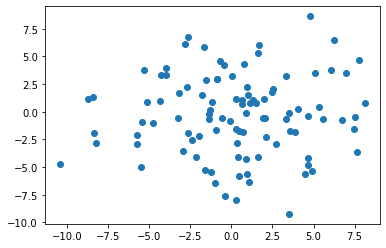

In [42]:
points = np.random.multivariate_normal(mean=(0,0), cov=[[13,0],[0,13]], size=(100,))
plt.scatter(points.T[0],points.T[1])
plt.show

In [15]:
def central_square(img_bin):
    #Takes image, returns centered crop which can be fully rotated (i.e. largest inner crop)
    #The diagonal of the inner crop should be as long as the images short_length
    centre = tuple(np.array(img_bin.shape[1::-1]) / 2)
    short_length = img_bin.shape[img_bin.shape == max(img_bin.shape)]
    long_length = max(img_bin.shape)
    print(short_length,long_length)

    diagonal = short_length
    crop_length = (short_length**2/2)**0.5
    print(crop_length)
    L1 = int(centre[0] - crop_length/2)
    L2 = int(centre[0] + crop_length/2)
    L3 = int(centre[1] - crop_length/2)
    L4 = int(centre[1] + crop_length/2)
    crop = [L1,L2,L3,L4]
    
    return crop

central_square(cv.imread('TestData/AgNWN_iso/LargeSet/30s/011/Binarized/slice0.tiff'))

1019 1536
720.541810029092


[407, 1128, 149, 869]